
## EDA: Order Items Analysis

This notebook focuses on understanding the structure and granularity of the **order_items** table and its implications for downstream data modeling.

## Analogy ##

<p align="center">
  <img src="OrderItems.png" width="1000"/>
</p>


### Key Observation: Table Grain and Modeling Implications

* Identified that the **grain of the order_items table** is at a composite level of **order_id, seller_id, and product_id**.

* This multi-dimensional grain means a single order can span **multiple rows**, representing different products and sellers within the same order.

* Since downstream datasets and marts are joined primarily at the **order_id level**, this table cannot be used directly for such joins.

* Total Order Value is calculated as (Price + Freight Value) * Total Items for unqiue combination of OrderID, SellerID, ProductID

* To address this, the table was **aggregated and transformed** by rolling up relevant metrics (e.g., item counts, prices, and other order-level measures) to the **order_id grain**.

* These aggregated, order-level features were then materialized in the **Mart layer**, ensuring consistency in joins and preventing data duplication in downstream analysis.



In [8]:
import pandas as pd
cart_items=pd.read_csv("../Source Data/olist_order_items_dataset.csv")

In [9]:
cart_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [10]:
cart_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


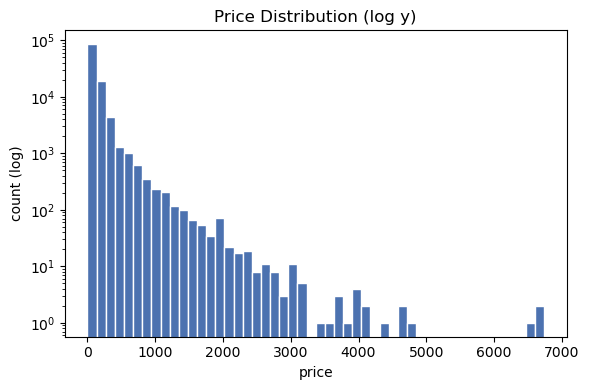

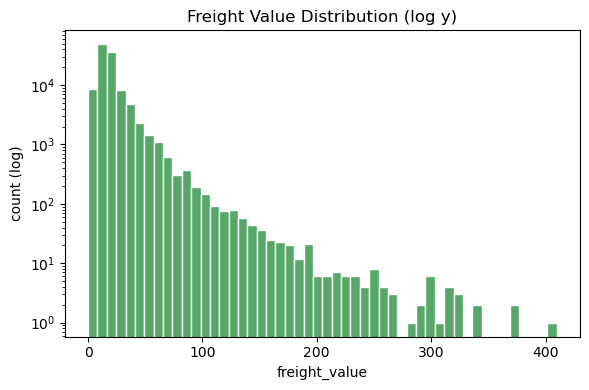

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))
plt.hist(cart_items["price"], bins=50, color="#4c72b0", edgecolor="white")
plt.yscale("log")
plt.title("Price Distribution (log y)")
plt.xlabel("price")
plt.ylabel("count (log)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(cart_items["freight_value"], bins=50, color="#55a868", edgecolor="white")
plt.yscale("log")
plt.title("Freight Value Distribution (log y)")
plt.xlabel("freight_value")
plt.ylabel("count (log)")
plt.tight_layout()
plt.show()


In [12]:
cart_items.duplicated("order_id").sum()

13984

In [13]:
dup_order_id = (
    cart_items.groupby("order_id")
    .size()
)
dup_order_id.sort_values(ascending=False).head(10)


order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
9bdc4d4c71aa1de4606060929dee888c    14
73c8ab38f07dc94389065f7eba4f297a    14
37ee401157a3a0b28c9c6d0ed8c3b24b    13
2c2a19b5703863c908512d135aa6accc    12
c05d6a79e55da72ca780ce90364abed9    12
dtype: int64

In [14]:
cart_items.loc[cart_items["order_id"] =='8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


1. An orderID can have multiple ProductIds from Multiple Seller IDs.
2. To know the exact order value, we need to take count of Order_Item_Id for this combination [OrderId, ProductId, SellerID]
3. This will give us exact value of the Total Order Value for an OrderID i.e. SUM ((Price+Freight_Value)* Count of Items for [order_id, product_id, seller_id])